# Stationrank

In [1]:
import os
import time
import json
import pygraphviz

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import networkx as nx
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
from networkx.drawing.nx_agraph import write_dot
from networkx.readwrite import json_graph
from shapely.geometry import Point, LineString
from shapely_geojson import dump, dumps, Feature, FeatureCollection
from tqdm.notebook import trange, tqdm
from scipy.linalg import norm
from scipy.linalg import eig
from matplotlib import cm
from ipywidgets import interact, interact_manual
from datetime import datetime, timedelta
from numpy import linalg as LA
from numpy import nan

## Loading the dataset

In [4]:
# Set month
month = 'Oktober'

# Set index
imonth = '10'

In [5]:
# Clean data contains every "stop" for a month for all swiss railways
data = pd.read_pickle('data/istdaten/{}/data_clean_2019{}.pkl'.format(month, imonth))

In [6]:
# Check if all days are in
print(data.BETRIEBSTAG.unique())

['01.10.2019' '02.10.2019' '03.10.2019' '04.10.2019' '05.10.2019'
 '06.10.2019' '07.10.2019' '08.10.2019' '09.10.2019' '10.10.2019'
 '11.10.2019' '12.10.2019' '13.10.2019' '14.10.2019' '15.10.2019'
 '16.10.2019' '17.10.2019' '18.10.2019' '19.10.2019' '20.10.2019'
 '21.10.2019' '22.10.2019' '23.10.2019' '24.10.2019' '25.10.2019'
 '26.10.2019' '27.10.2019' '28.10.2019' '29.10.2019' '30.10.2019'
 '31.10.2019']


In [7]:
data.head()

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ABK,PRODUKT_ID,LINIEN_ID,LINIEN_TEXT,VERKEHRSMITTEL_TEXT,ZUSATZFAHRT_TF,FAELLT_AUS_TF,BPUIC,HALTESTELLEN_NAME,ANKUNFTSZEIT,AN_PROGNOSE,AN_PROGNOSE_STATUS,ABFAHRTSZEIT,AB_PROGNOSE,AB_PROGNOSE_STATUS,DURCHFAHRT_TF
247,01.10.2019,80:L7____:87875:000,SBB,Zug,87875,S6,S,False,False,8500090,Basel Bad Bf,01.10.2019 01:14,NaN,UNBEKANNT,NaN,NaN,PROGNOSE,False
416,01.10.2019,85:11:100:001,SBB,Zug,100,ICE,ICE,False,False,8500010,Basel SBB,NaN,NaN,PROGNOSE,01.10.2019 19:13,01.10.2019 19:14:39,REAL,False
417,01.10.2019,85:11:100:001,SBB,Zug,100,ICE,ICE,False,False,8500090,Basel Bad Bf,01.10.2019 19:19,01.10.2019 19:19:24,PROGNOSE,01.10.2019 19:23,01.10.2019 19:23:24,PROGNOSE,False
418,01.10.2019,85:11:1007:001,SBB,Zug,1007,IC4,IC,False,False,8503424,Schaffhausen,NaN,NaN,PROGNOSE,01.10.2019 05:47,01.10.2019 05:47:53,REAL,False
419,01.10.2019,85:11:1007:001,SBB,Zug,1007,IC4,IC,False,False,8503000,Zürich HB,01.10.2019 06:23,01.10.2019 06:23:09,REAL,NaN,NaN,PROGNOSE,False


## Load stations dataset (didok)

In [8]:
# Full didok data
didok = pd.read_csv('data/istdaten/{}/dienststellenfull.csv'.format(month), header=6, sep=";")

In [9]:
# Coordinates
didok = didok[['BPUIC', 'BEZEICHNUNG_OFFIZIELL', 'E_WGS84', 'N_WGS84']].drop_duplicates()
didok = didok[np.isfinite(didok['E_WGS84'])]
didok = didok.reset_index()
didok = didok.drop(columns=['index'])
didok.head(5)

,BPUIC,BEZEICHNUNG_OFFIZIELL,E_WGS84,N_WGS84
0,8504048,"Villariaz, Moulin Rouge",-14.801849,35.100356
1,8504049,"Villarepos, F. de Plan",-14.764508,35.330601
2,8519024,Basel SBB RB West,-8.092301,55.603118
3,8519025,Basel SBB RB Ost,-8.073794,55.600495
4,8557043,"Ennetbaden, Rütenen-Felmen",0.379039,47.265918


### Locations in project as BPUIC

In [10]:
# These are the specific stations of the project
locations = data.copy(deep=True)
locations = locations[['HALTESTELLEN_NAME', 'BPUIC']].drop_duplicates()
locations.BPUIC = locations.BPUIC.astype(int)
locations = locations.reset_index()
locations = locations.drop(columns=['index'])
locations

,HALTESTELLEN_NAME,BPUIC
0,Basel Bad Bf,8500090
1,Basel SBB,8500010
2,Schaffhausen,8503424
3,Zürich HB,8503000
4,Bern,8507000
...,...,...
1240,Genève-Champel,8516272
1241,Lancy-Bachet,8517142
1242,Genève Voie-Creuse,8519692
1243,Niederbottigen BN,8504492


### Georeferenced locations by BPUIC

In [11]:
geopos = []
abbreviation = []
for i, location in enumerate(locations.values):
    lon = didok.loc[didok['BPUIC']==location[1]].values[0][2]
    lat = didok.loc[didok['BPUIC']==location[1]].values[0][3]
    loc = [lon, lat]
    geopos.append(loc)

In [12]:
locations['geopos'] = geopos
locations.head(5)

,HALTESTELLEN_NAME,BPUIC,geopos
0,Basel Bad Bf,8500090,"[7.60728379, 47.56814685]"
1,Basel SBB,8500010,"[7.58955093, 47.54740464]"
2,Schaffhausen,8503424,"[8.632719999999999, 47.69827999]"
3,Zürich HB,8503000,"[8.540189999999999, 47.378170000000004]"
4,Bern,8507000,"[7.43911848, 46.94882499]"


## Preprocessing

In [ ]:
def discretize(x):
    if pd.isna(x):
        return None
    else:
        x = pd.to_datetime(x)
        return int((x.hour) * 60 + x.minute)

In [ ]:
def span(x):
    if pd.isna(x['arrival']) ^ pd.isna(x['departure']):
        return 1
    elif pd.isna(x['arrival']) and pd.isna(x['departure']):
        return None
    else:
        diff = x['departure'] - x['arrival']
        if diff >= 0:
            return diff + 1
        else:
            return None

In [ ]:
def timeline(lst, df):
    if pd.isna(df.loc[df.index[0]].arrival):
        start = int(df.loc[df.index[0]].departure)
    else:
        start = int(df.loc[df.index[0]].arrival)
    primer = {int(i): None for i in range(0, start)}
    main = {int(j + start): [lst[j]] for j in range(0, len(lst))}
    sequel = {int(k): None for k in range(start + len(lst), 60 * 24)}
    main.update(sequel)
    primer.update(main)
    return primer

In [ ]:
# Collect features
features = []
# One feature per day
for day in data['BETRIEBSTAG'].unique():
    feature = data[data['BETRIEBSTAG'] == day]
    # Reset index
    feature = feature.reset_index()
    feature = feature.drop(columns=['index'])
    features.append(feature)

In [ ]:
# Collect diaries
diaries = []

for feature in tqdm(features):

    # Diary of routes
    diary = []
    for route in tqdm(
            feature.FAHRT_BEZEICHNER.unique(),
            desc=feature['BETRIEBSTAG'].unique()[0]):

        df = feature.loc[(feature.FAHRT_BEZEICHNER == route)]

        if len(df['HALTESTELLEN_NAME']) > 1:

            df['arrival'] = df['ANKUNFTSZEIT'].apply(discretize)
            df['departure'] = df['ABFAHRTSZEIT'].apply(discretize)

            # Sort routes by scheduled departure
            df = df.sort_values(
                by='ABFAHRTSZEIT', ascending=True, na_position='last')

            df['dwell'] = df[['arrival', 'departure']].apply(span, axis=1)
            df['running'] = df['arrival'].shift(-1) - df['departure'] - 1

            # Check for timetable errors
            if any(df['running'].values.ravel() < 0):
                continue
            if any(df['dwell'].values.ravel() < 0):
                continue

            df['next'] = df['HALTESTELLEN_NAME'].shift(-1)

            sentence = []
            for i, j, k, l in df[[
                    'HALTESTELLEN_NAME', 'next', 'dwell', 'running'
            ]].values:
                if pd.isna(j) or pd.isna(l):
                    sentence.append([i])
                    
                elif pd.isna(k):
                    sentence.append([i])
                    break
                else:
                    sentence.append([i] * int(k))
                    sentence.append([i + '=>' + j] * int(l))

            flattened = [item for sublist in sentence for item in sublist]
            dic = timeline(flattened, df)
            if len(dic) != 1440:
                print(len(dic))
                break
            diary.append(dic)

    # Fill in the diaries
    diaries.append(pd.DataFrame(diary))

## Save the diaries for later use

In [ ]:
# Export all diaries
for i, diary in enumerate(diaries):
    path = 'data/istdaten/{}/diaries/diary_{:>02}_2019{}.pkl'.format(
        month, str(i + 1), imonth)
    diary.to_pickle(path)

## Load preprocessed data

In [ ]:
Diaries = []
directory = 'data/istdaten/{}/diaries/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory, file)
    d = pd.read_pickle(path)
    Diaries.append(d)

## Model construction

In [ ]:
# Collect starting vectors
vectors = []
# Collect transition matrices
matrices = []
# Collect states
states = []

In [ ]:
for diary in tqdm(Diaries):

    # Dictionary of stations
    dic = {'station': np.unique([x for x in diary.values.ravel() if x != None])}
    stations = pd.DataFrame(dic)
    states.append(stations)

    # Size of the matrix
    n = stations.shape[0]
    
    # Initialize a n*1 initial start vector
    t = (n)
    Vector = pd.DataFrame(np.zeros(t))
    origin = pd.DataFrame(np.zeros(t))
    
    # Initialize a n*n transition matrix
    s = (n, n)
    matrix = pd.DataFrame(np.zeros(s))

    for row in tqdm(diary.values):
        route = [x for x in row if x != None]
        stops = [item for sublist in route for item in sublist]
          
        # Initial vector
        pos_i = stations.loc[stations['station'] == stops[0]].index[0]
        origin.iloc[pos_i] += 1

        # Transition matrix
        for i in range(len(stops) - 1):
            pos1 = stations.loc[stations['station'] == stops[i]].index[0]
            pos2 = stations.loc[stations['station'] == stops[i + 1]].index[0]  
            matrix.iloc[pos1, pos2] += 1
            
    # Fill in the vectors
    inflow = matrix.sum(axis=0)
    outflow = matrix.sum(axis=1)
    
    Vector['station'] = dic['station']
    Vector['origin'] = origin/origin.sum()
    Vector['inflow'] = inflow/inflow.sum()
    Vector['outflow'] = outflow/outflow.sum()
    Vector = Vector.drop(columns=[0])
    vectors.append(Vector)

    # Fill in the matrices
    matrix.columns = dic['station']
    matrix = matrix.set_index(dic['station'])
    matrices.append(matrix)

### Save the model for later use

In [ ]:
# Export all vectors
for i, vector in enumerate(vectors):
    path = 'data/istdaten/{}/vectors/vector_{:>02}_2019{}.pkl'.format(
        month, str(i + 1), imonth)
    vector.to_pickle(path)

In [ ]:
# Export all matrices
for i, matrix in enumerate(matrices):
    path = 'data/istdaten/{}/matrices/matrix_{:>02}_2019{}.pkl'.format(
        month, str(i + 1), imonth)
    matrix.to_pickle(path)

### Loading the model

In [546]:
# Load starting vectors
Vs = []
directory = 'data/istdaten/{}/vectors/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory, file)
    V = pd.read_pickle(path)
    Vs.append(V)

In [312]:
# Load transition matrices
TMs = []
directory = 'data/istdaten/{}/matrices/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory,file)
    TM = pd.read_pickle(path)
    TMs.append(TM)

In [313]:
strings = []
for i in range(1, len(Vs)+1):
    string = '{:>02}.{}.2019'.format(i, imonth)
    strings.append(string)

## Calculate Probabilities

In [ ]:
# Now convert to probabilities
singularities = []
for i, TM in tqdm(enumerate(TMs)):
    eps = .001
    count = 0
    for row in tqdm(TM.values):
        singularities.append([])
        s = sum(row)
        k = 0
        if sum(f > 0 for k, f in enumerate(row)) == 1 and count==k:
            print('Absorbing state at', Vs[i].iloc[count][0], i, '\n')
            row[:] = eps
            row[count] = 1.0
            row[:] = [f/sum(row) for f in row]
        if s == 0:
            singularity = Vs[i].iloc[count][0]
            singularities[i].append(singularity)
            print('Singularity at', singularity, i, '\n')
            row[:] = eps
            row[count] = 1.0
            _s = sum(row)
            row[:] = [f/_s for f in row]
        else:
            row[:] = [f/s for f in row]
        TM.values[count]=row
        count+=1

In [319]:
# Overview of singularities in the system by day of occurance
singular = pd.DataFrame(singularities).dropna(how ='all')
singular

,0
2,Chiasso Olimpino I
7,Sagliains Abzw Sasslatschtunne
14,Wil
16,Gaggiolo Confine
19,La Plaine-Frontière
22,Le Locle-Frontière
28,Genève Voie-Creuse


In [317]:
# Export all probabilities
for i, probability in enumerate(TMs):
    path = 'data/istdaten/{}/probability/probability_{:>02}_2019{}.pkl'.format(
        month, str(i + 1), imonth)
    probability.to_pickle(path)

In [323]:
# Load probabilities
TMs = []
directory = 'data/istdaten/{}/probability/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory,file)
    TM = pd.read_pickle(path)
    TMs.append(TM)

In [324]:
# Matrix size
sizes = []
for TM in TMs:
    size = TM.shape[0]
    sizes.append(size)

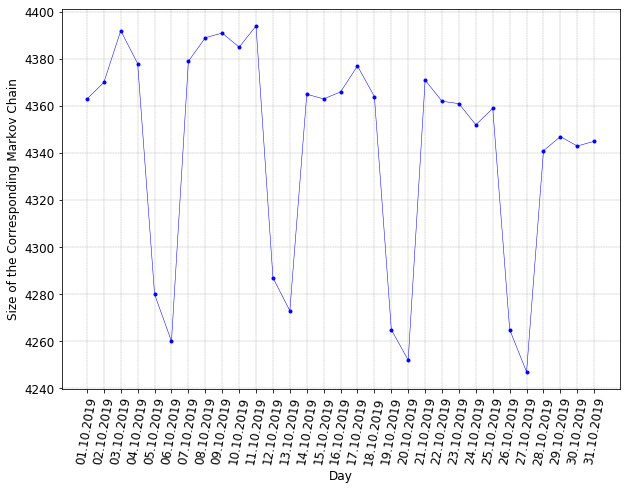

In [325]:
# Plot size
fig = plt.figure(figsize=(10, 7));
plt.plot(sizes, '.-b', linewidth=.51)
font = {'size': 12}
plt.rc('font', **font)
plt.ylabel('Size of the Corresponding Markov Chain')
plt.xlabel('Day')
xticks=[s for s in strings]
plt.xticks(range(len(sizes)), xticks, rotation=80, horizontalalignment='center')

plt.grid(linewidth=.31, color='gray', linestyle='--')

plt.show()
plt.close()

## Analysis

In [326]:
def simulate_markov(TM, verbose='on'):
    e1 = time.time()
    states_n = TM.shape[0]
    pi = np.ones(states_n)
    pi1 = np.zeros(states_n)
    pi = np.random.rand(states_n)
    pi = pi / pi.sum()

    n = norm(pi - pi1)
    i = 0
    diff = []
    while n > 1e-6 and i < 1 * 1e4:
        pi1 = TM.T.dot(pi).copy()
        n = norm(pi - pi1)
        i += 1
        diff.append(n)
        pi = pi1.copy()
    if verbose == 'on':
        print("Iterating {} times in {}".format(i, time.time() - e1))

    mixing_ = i

    return pi1, mixing_

### Using Power Iteration to calculate the steady state probabilities, Pi

In [327]:
Pi = []
Mixing_times = []

for TM in TMs:
    t, mixing_ = simulate_markov(TM)
    Pi.append(t)
    Mixing_times.append(mixing_)

Iterating 1742 times in 14.060036420822144
Iterating 1653 times in 12.839000225067139
Iterating 1967 times in 14.750997304916382
Iterating 1646 times in 12.894032955169678
Iterating 1922 times in 14.574995756149292
Iterating 1902 times in 14.839998245239258
Iterating 1895 times in 15.471997022628784
Iterating 1990 times in 15.53700065612793
Iterating 1745 times in 13.745007753372192
Iterating 1839 times in 13.703991174697876
Iterating 1913 times in 14.246009826660156
Iterating 1845 times in 13.299009323120117
Iterating 2162 times in 15.787996530532837
Iterating 2263 times in 17.693999528884888
Iterating 1785 times in 13.97900390625
Iterating 2164 times in 17.596001386642456
Iterating 1922 times in 15.880002975463867
Iterating 1824 times in 15.08299994468689
Iterating 2243 times in 18.05400013923645
Iterating 2357 times in 17.32599139213562
Iterating 1853 times in 14.765997648239136
Iterating 2157 times in 15.988999128341675
Iterating 2086 times in 15.494002342224121
Iterating 2202 time

### Calculating the Kemeny constant

In [328]:
def Kemeny_constant(MC):
    eigval, vl, vr = eig(MC, left=True)
    eigval = np.real(eigval)
    vl = np.real(vl)

    eigvec_1 = vl[:, np.argmax(np.abs(
        eigval))] / vl[:, np.argmax(np.abs(eigval))].sum()
    ind = np.around(eigval, decimals=8) != 1
    return np.divide(1, (1 - eigval[ind])).sum(), eigvec_1

In [330]:
Kemenys = []
pi_list = []

for TM in TMs:
    A = TM.values
    K, pi = Kemeny_constant(A)
    print(K, np.sum(pi))
    Kemenys.append(K)
    pi_list.append(pi)

43959.8825048111 0.9999999999999999
43922.45514977431 0.9999999999999999
43777.00258882306 0.9999999999999999
44468.39196292674 1.0
43964.078741252495 1.0
42855.63424980233 1.0
44256.855325282566 1.0
44268.587930515845 0.9999999999999998
44548.20381895617 1.0
44247.0452929616 0.9999999999999999
44715.06645237755 1.0
43388.406890613085 1.0
42742.28291341037 1.0
44532.77467673202 1.0000000000000002
44666.754391213864 1.0
45010.956579145524 1.0
45115.127514082094 1.0000000000000002
45330.085870735216 1.0000000000000002
43255.34526657176 1.0
42411.0382496532 1.0
44881.745752098635 1.0
44799.48953938538 1.0
44622.34132647619 1.0
45073.73257161239 0.9999999999999998
44894.78094648742 0.9999999999999998
42638.14989684252 1.0000000000000002
41709.24836804976 0.9999999999999999
44524.483367190725 0.9999999999999999
44039.427673211365 1.0
44180.908063879826 1.0
44288.04018424022 1.0


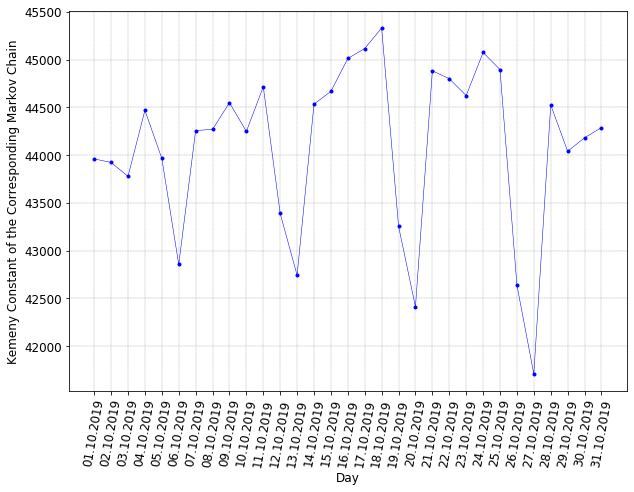

In [331]:
fig = plt.figure(figsize=(10, 7))
plt.plot(Kemenys, '.-b', linewidth=.51)

font = {'size': 12}
plt.rc('font', **font)

plt.grid(linewidth=.31, color='gray', linestyle='--')
plt.xlabel('Day')
plt.ylabel('Kemeny Constant of the Corresponding Markov Chain')
xticks = [s for s in strings]
plt.xticks(
    range(len(TMs)),
    xticks,
    rotation=80,
    horizontalalignment='center')

plt.show()
plt.close()

## Results

In [551]:
# Steady distribution of stations
steady_states = []
for i, vector in enumerate(Vs):
    Steady_dist = vector
    Steady_dist['Pi'] = Pi[i].values
    Steady_dist['Date'] = str(datetime(year=2019, month=10, day=int(i + 1)))
    Steady_dist['Flag'] = ~Steady_dist['station'].str.contains('=>')
    Steady_dist = Steady_dist[Steady_dist['Flag']]
    steady_states.append(Steady_dist)

In [552]:
# Compute pagerank
stationranks = []

for steady in steady_states:
    stationrank = steady.sort_values(['Pi'], ascending=False)
    stationrank = stationrank.reset_index()
    stationrank = stationrank.drop(columns=['index'])
    stationranks.append(stationrank)

In [553]:
# Stationrank
@interact
def rank(day=(0, len(stationranks) - 1)):
    return stationranks[day]

interactive(children=(IntSlider(value=15, description='day', max=30), Output()), _dom_classes=('widget-interac…

In [555]:
# Correlation
@interact
def scatter(day=(0, len(stationranks) - 1)):
    cmap = cm.get_cmap('Spectral_r')
    fig, ax = plt.subplots(figsize=(5.5,5))
    stationranks[day].plot.scatter(x='inflow', y='Pi', s=5, c='origin', cmap=cmap, ax=ax) 

interactive(children=(IntSlider(value=15, description='day', max=30), Output()), _dom_classes=('widget-interac…

## Clustering

In [394]:
from sompy import mapview
from sompy.sompy import SOMFactory

In [395]:
# Steady distribution of stations
steady_states = []
for i, vector in enumerate(Vs):
    Steady_dist = vector
    Steady_dist['Pi'] = pi_list[i]
    Steady_dist['Date'] = str(datetime(year=2019, month=10, day=int(i + 1)))
    Steady_dist['Flag'] = ~Steady_dist['station'].str.contains('=>')
    Steady_dist = Steady_dist[Steady_dist['Flag']]
    steady_states.append(Steady_dist)

In [396]:
selected_states = []
for state in steady_states:
    state = state[state['Flag']]
    state.set_index('station', inplace=True)
    selected_states.append(state)

In [397]:
# Merge stations over whole month
merge = pd.concat(selected_states, axis=1, join='inner')

In [398]:
Data = np.concatenate(
    (merge['origin'].values[:], merge['inflow'].values[:],
     merge['outflow'].values[:], merge['Pi'].values[:]),
    axis=1)

In [704]:
len(merge['Pi'].T.values[:][0])

1194

In [707]:
merge['Pi'].T.values[0]

array([1.68415833e-04, 1.09994316e-03, 6.75014813e-05, ...,
       4.34073782e-04, 1.50538836e-04, 3.00924213e-04])

In [708]:
merge['Pi'].T.values[:][0]

array([1.68415833e-04, 1.09994316e-03, 6.75014813e-05, ...,
       4.34073782e-04, 1.50538836e-04, 3.00924213e-04])

In [399]:
# Normalize along the rows!
row_sums = Data.sum(axis=1)
Normal = Data / row_sums[:, np.newaxis]

In [400]:
names = []
for what in [
        'origin', 'inflow', 'outflow', 'Pi'
]:
    for day in range(0, len(TMs)):
        names.append(what + '-' + str(1+day))

### 2-dimensional SOM

In [401]:
msz10 = 60
msz11 = 60

In [402]:
sm = SOMFactory().build(
    Normal, mapsize=[msz10, msz11], initialization='pca', component_names=names)
sm.train(n_job=1, verbose=False, train_rough_len=20, train_finetune_len=50)

In [403]:
topographic_error = sm.calculate_topographic_error()
quantization_error = np.mean(sm._bmu[1])
print("Topographic error = %s; Quantization error = %s" % (topographic_error,
                                                           quantization_error))

Topographic error = 0.0; Quantization error = 0.4643701363998062


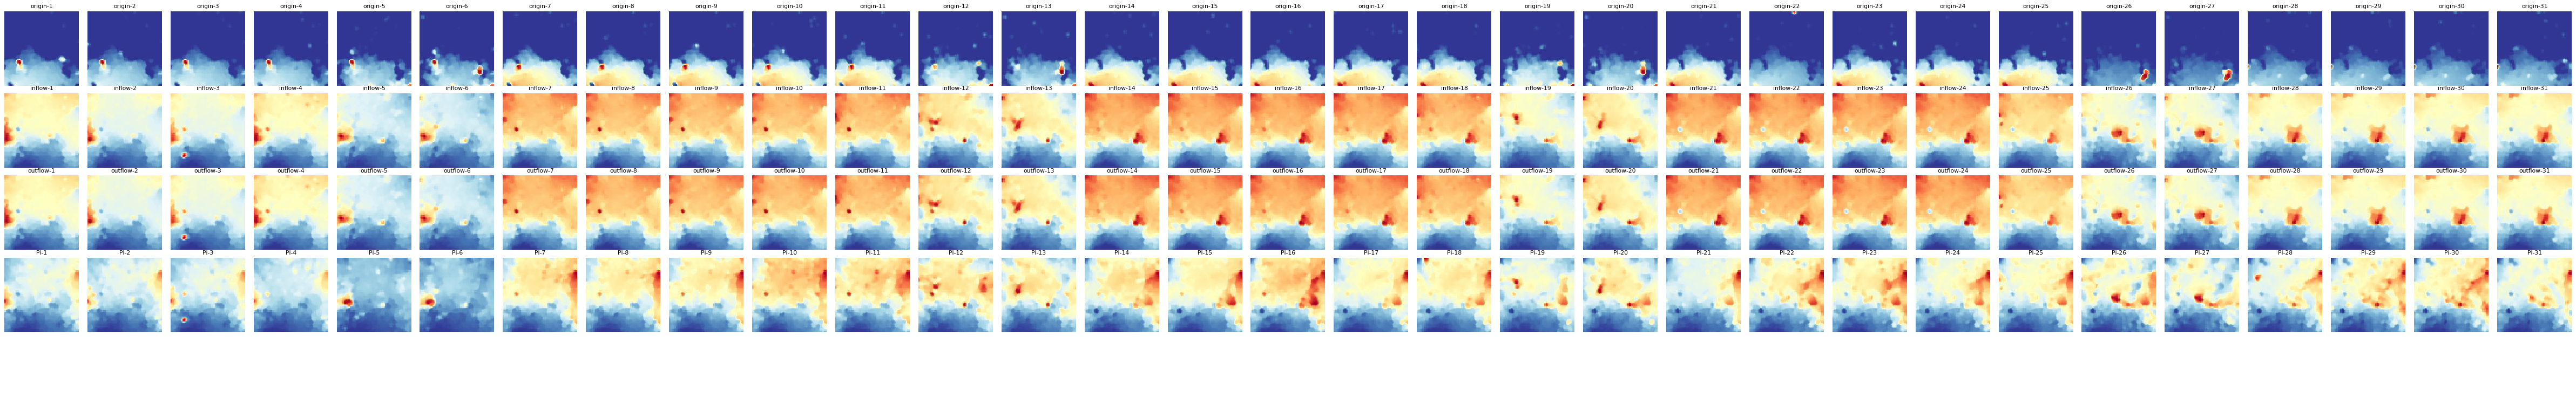

In [404]:
from sompy.visualization.mapview import View2DPacked
atlas = View2DPacked(20, 20, '', text_size=9)
atlas.show(sm, col_sz=31, which_dim="all")

### 1-dimensional SOM with contextual numbers

In [405]:
msz10 = 3600
msz11 = 1

In [406]:
sm = SOMFactory().build(
    Normal, mapsize=[msz10, msz11], initialization='pca', component_names=names)
sm.train(n_job=1, verbose=False, train_rough_len=40, train_finetune_len=100)

In [407]:
topographic_error = sm.calculate_topographic_error()
quantization_error = np.mean(sm._bmu[1])
print("Topographic error = %s; Quantization error = %s" % (topographic_error,
                                                           quantization_error))

Topographic error = 0.0; Quantization error = 0.17023283869725622


In [431]:
# Get contextual numbers
proj = sm.project_data(Data)
# How many clusters identified
len(set(proj))

37

In [432]:
# Euclidean metric of weights
w = sm.calculate_map_dist()
HDist = []
for i, _ in enumerate(w):
    if i>=1:
        HDist.append(np.linalg.norm(w[i]-w[i-1]))
HDist = HDist/min(HDist)

In [433]:
# Calclulate adjusted contextual numbers (ACNs)
acn = []
ACN = 0
acn.append(ACN)
for i in range(1, len(HDist)+1):
    ACN = ACN + HDist[i-1]
    acn.append(ACN)

In [434]:
# Match results to ACNs
newproj=[]
for pr in proj:
    newpr = acn[pr]
    newproj.append(newpr)

In [495]:
# Interpolate between 0 and 1
interpol = np.interp(newproj, (min(newproj), max(newproj)), (0, 1))

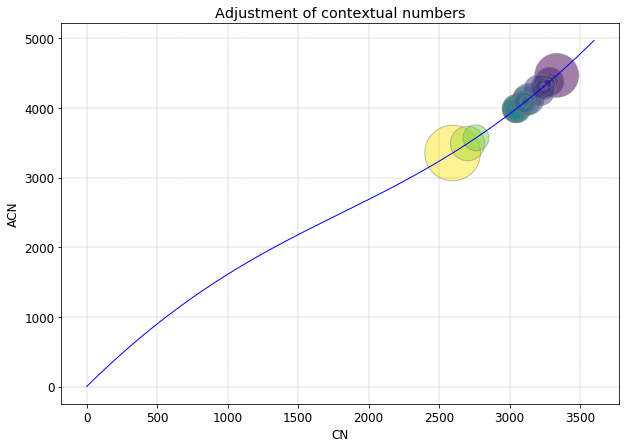

In [722]:
x = np.arange(0, len(acn), 1)
y = acn

font = {'size': 12}
plt.rc('font', **font)

fig = plt.figure(figsize=(10, 7))
plt.plot(x, y, 'b', linewidth=1)
plt.grid(linewidth=.31, color='gray', linestyle='--')
plt.title('Adjustment of contextual numbers')
plt.xlabel('CN')
plt.ylabel('ACN')
plt.scatter(
    proj,
    newproj,
    c=interpol,
    s=pow(10, 5.5) * merge['Pi'].T.values[0],
    alpha=0.5,
    cmap=plt.cm.viridis_r,
    edgecolor='grey')
plt.show()
plt.close()

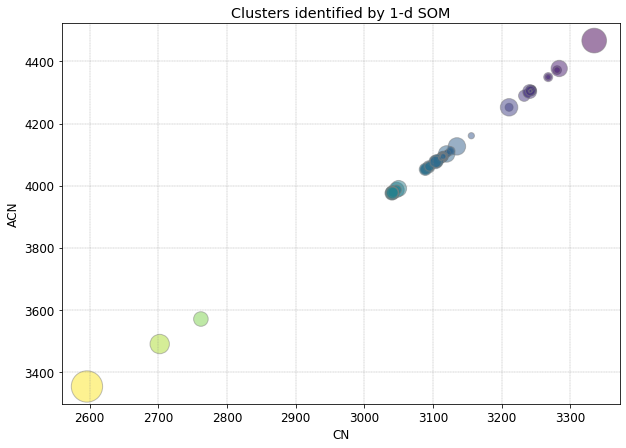

In [721]:
x = np.arange(0, len(acn), 1)
y = acn

font = {'size': 12}
plt.rc('font', **font)

fig = plt.figure(figsize=(10, 7))
plt.grid(linewidth=.31, color='gray', linestyle='--')
plt.title('Clusters identified by 1-d SOM')
plt.xlabel('CN')
plt.ylabel('ACN')
plt.scatter(
    proj,
    newproj,
    c=interpol,
    s=pow(10, 5) * merge['Pi'].T.values[0],
    alpha=0.5,
    cmap=plt.cm.viridis_r,
    edgecolor='grey')
plt.show()
plt.close()

In [496]:
# Load starting vectors
Vs = []
directory = 'data/istdaten/{}/vectors/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory, file)
    V = pd.read_pickle(path)
    Vs.append(V)

In [497]:
# Steady distribution of stations
steady_states = []
for i, vector in enumerate(Vs):
    Steady_dist = vector
    Steady_dist['Pi'] = pi_list[i]
    Steady_dist['Date'] = str(datetime(year=2019, month=10, day=int(i + 1)))
    Steady_dist['Flag'] = Steady_dist['station'].isin(indices)  
    Steady_dist.set_index('station')
    Steady_dist_ = Steady_dist[Steady_dist['Flag']]    
    Steady_dist_['color'] = interpol
    Steady_dist = Steady_dist.merge(Steady_dist_, how='outer')
    Steady_dist = Steady_dist.fillna(0)
    Steady_dist.set_index('station', inplace=True)
    steady_states.append(Steady_dist)

In [498]:
interact(
    plot_station_graph,
    index=(0, 30),
    geo={True, False},
    labels={True, False},
    clusters={True, False});

interactive(children=(IntSlider(value=15, description='index', max=30), Dropdown(description='geo', index=1, o…

## Sensitivity analysis of Markov chains

In [556]:
# Sensitivity analysis on a single node
def change_node(M, i, percent=-99):
    eps = .001
    MC = M.copy()
        
    MC[i, :] = MC[i, :] * (1 + percent * .01)
    MC[:, i] = MC[:, i] * (1 + percent * .01)
    MC[i, i] = MC[i, i] / (1 + percent * .01)

    for i in range(MC.shape[0]):
        s = sum(MC[i])
        
        if s == 0:
            MC[i] = eps
            MC[i, i] = 1.
            s = sum(MC[i])
            MC[i] = np.divide(MC[i], s)

        else:
            MC[i] = np.divide(MC[i], s)

    return MC

In [ ]:
percent = -99.9
blackout_stations = ['Bern', 'Chur', 'Zürich HB']
#blackout_stations = list(indices)

for d in trange(len(TMs)):
    TM = TMs[d].copy(deep=True)

    names_perturbed = []
    indices_perturbated = []

    Kemenys_perturbed = []
    Kemenys_diff = []

    Pi_perturbed = []
    Pi_diff = []

    e0 = time.time()

    K_normal, _ = Kemeny_constant(TM)
    pi_normal, _ = simulate_markov(TM, verbose='off')

    for station in blackout_stations:
        ind = np.where(TM.index == station)[0][0]
        Perturbed_TM = change_node(TM.values, ind, percent)

        K, _ = Kemeny_constant(Perturbed_TM)
        pi, _ = simulate_markov(Perturbed_TM, verbose='off')

        if np.any(pi < 0):
            flag = True
            print('something went wrong!')
        else:
            flag = False
            indices_perturbated.append(ind)
            names_perturbed.append(station)
            Kemenys_perturbed.append(K)
            Kemenys_diff.append(100 * (K - K_normal) / K_normal)
            Pi_perturbed.append(pi)
            Pi_diff.append(np.asarray(100 * (pi - pi_normal) / pi_normal))

    print("Sensitivity of TM {}, in {} second".format(
        datetime(year=2019, month=10, day=int(d + 1)),
        time.time() - e0))

    if not flag:
        DF = pd.DataFrame(
            index=names_perturbed, data=np.asarray(Pi_diff), columns=TM.index)
        path = 'data/istdaten/{}/perturbations/Pi_diff_{}_{:>02}{}2019.pkl'.format(
            month, str(percent), str(d + 1), imonth)
        DF.to_pickle(path)

        DF = pd.DataFrame(
            index=['pi_normal'],
            data=np.asarray(pi_normal)[np.newaxis, :],
            columns=TM.index)
        path = 'data/istdaten/{}/perturbations/pi_normal_{}_{:>02}{}2019.pkl'.format(
            month, str(percent), str(d + 1), imonth)
        DF.to_pickle(path)

        DF = pd.DataFrame(
            index=names_perturbed,
            data=np.asarray(Kemenys_diff),
            columns=['Kemeny_Change_PCT'])
        path = 'data/istdaten/{}/perturbations/Kemenys_diff_{}_{:>02}{}2019.pkl'.format(
            month, str(percent), str(d + 1), imonth)
        DF.to_pickle(path)

        DF = pd.DataFrame(
            index=names_perturbed,
            data=np.asarray(Pi_perturbed),
            columns=TM.index)
        path = 'data/istdaten/{}/perturbations/Pi_perturbed_{}_{:>02}{}2019.pkl'.format(
            month, str(percent), str(d + 1), imonth)
        DF.to_pickle(path)

In [ ]:
percent = -99.9
#blackout_stations = ['Bern', 'Chur', 'Zürich HB']
blackout_stations = list(indices)
d = 15
#for d in trange(len(TMs)):
TM = TMs[d].copy(deep=True)

names_perturbed = []
indices_perturbated = []

Kemenys_perturbed = []
Kemenys_diff = []

Pi_perturbed = []
Pi_diff = []

e0 = time.time()

K_normal, _ = Kemeny_constant(TM)
pi_normal, _ = simulate_markov(TM, verbose='off')

for station in tqdm(blackout_stations):
    ind = np.where(TM.index == station)[0][0]
    Perturbed_TM = change_node(TM.values, ind, percent)

    K, _ = Kemeny_constant(Perturbed_TM)
    pi, _ = simulate_markov(Perturbed_TM, verbose='off')

    if np.any(pi < 0):
        flag = True
        print('something went wrong!')
    else:
        flag = False
        indices_perturbated.append(ind)
        names_perturbed.append(station)
        Kemenys_perturbed.append(K)
        Kemenys_diff.append(100 * (K - K_normal) / K_normal)
        Pi_perturbed.append(pi)
        Pi_diff.append(np.asarray(100 * (pi - pi_normal) / pi_normal))

print("Sensitivity of TM {}, in {} second".format(
    datetime(year=2019, month=10, day=int(d + 1)),
    time.time() - e0))

if not flag:
    DF = pd.DataFrame(
        index=names_perturbed, data=np.asarray(Pi_diff), columns=TM.index)
    path = 'data/istdaten/{}/perturbations/Pi_diff_{}_{:>02}{}2019.pkl'.format(
        month, str(percent), str(d + 1), imonth)
    DF.to_pickle(path)

    DF = pd.DataFrame(
        index=['pi_normal'],
        data=np.asarray(pi_normal)[np.newaxis, :],
        columns=TM.index)
    path = 'data/istdaten/{}/perturbations/pi_normal_{}_{:>02}{}2019.pkl'.format(
        month, str(percent), str(d + 1), imonth)
    DF.to_pickle(path)

    DF = pd.DataFrame(
        index=names_perturbed,
        data=np.asarray(Kemenys_diff),
        columns=['Kemeny_Change_PCT'])
    path = 'data/istdaten/{}/perturbations/Kemenys_diff_{}_{:>02}{}2019.pkl'.format(
        month, str(percent), str(d + 1), imonth)
    DF.to_pickle(path)

    DF = pd.DataFrame(
        index=names_perturbed,
        data=np.asarray(Pi_perturbed),
        columns=TM.index)
    path = 'data/istdaten/{}/perturbations/Pi_perturbed_{}_{:>02}{}2019.pkl'.format(
        month, str(percent), str(d + 1), imonth)
    DF.to_pickle(path)

### Blackout Bern

In [633]:
# Load starting vectors
Vs = []
directory = 'data/istdaten/{}/vectors/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory, file)
    V = pd.read_pickle(path)
    Vs.append(V)

In [634]:
# Steady distribution of stations
steady_states = []
for i, vector in enumerate(Vs):
    Steady_dist = vector
    Steady_dist['Pi'] = pi_list[i]
    Steady_dist['Date'] = str(datetime(year=2019, month=10, day=int(i + 1)))
    Steady_dist['Flag'] = Steady_dist['station'].isin(indices)
    pi_diff_path = 'data/istdaten/{}/perturbations/Pi_diff_{}_{:>02}{}2019.pkl'.format(
                month, str(percent), str(i + 1), imonth)
    pi_diff = pd.read_pickle(pi_diff_path)
    array = []
    for j, boo in enumerate(Steady_dist['Flag']):
        if boo:
            array.append(pi_diff.loc['Bern'].values[j])
        else:
            array.append(min(pi_diff.loc['Bern'].values))
    Steady_dist['color'] = array
    Steady_dist.set_index('station', inplace=True)
    steady_states.append(Steady_dist)

In [635]:
@interact
def scatter(day=(0, len(Vs) - 1)):
    x = np.arange(0, steady_states[day].shape[0], 1)
    y = steady_states[day].color.values

    font = {'size': 12}
    plt.rc('font', **font)

    fig = plt.figure(figsize=(15, 7))
    plt.scatter(
        x,
        y,
        c=steady_states[day].color,
        s=steady_states[day].Pi * pow(10, 5.5) * steady_states[day].Flag,
        alpha=0.5,
        cmap=plt.cm.viridis_r)
    plt.grid(linewidth=.31, color='gray', linestyle='--')
    plt.title('Pi Reduction')
    plt.xlabel('Nodes')
    plt.ylabel('PCT')
    plt.show()
    plt.close()

interactive(children=(IntSlider(value=15, description='day', max=30), Output()), _dom_classes=('widget-interac…

In [581]:
interact(
    plot_station_graph,
    index=(0, 30),
    geo={True, False},
    labels={True, False},
    clusters={True, False});

interactive(children=(IntSlider(value=15, description='index', max=30), Dropdown(description='geo', index=1, o…

### Blackout Chur

In [622]:
# Load starting vectors
Vs = []
directory = 'data/istdaten/{}/vectors/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory, file)
    V = pd.read_pickle(path)
    Vs.append(V)

In [623]:
# Steady distribution of stations
steady_states = []
for i, vector in enumerate(Vs):
    Steady_dist = vector
    Steady_dist['Pi'] = pi_list[i]
    Steady_dist['Date'] = str(datetime(year=2019, month=10, day=int(i + 1)))
    Steady_dist['Flag'] = Steady_dist['station'].isin(indices)
    pi_diff_path = 'data/istdaten/{}/perturbations/Pi_diff_{}_{:>02}{}2019.pkl'.format(
                month, str(percent), str(i + 1), imonth)
    pi_diff = pd.read_pickle(pi_diff_path)
    array = []
    for j, boo in enumerate(Steady_dist['Flag']):
        if boo:
            array.append(pi_diff.loc['Chur'].values[j])
        else:
            array.append(min(pi_diff.loc['Chur'].values))
    Steady_dist['color'] = array
    Steady_dist.set_index('station', inplace=True)
    steady_states.append(Steady_dist)

In [632]:
@interact
def scatter(day=(0, len(Vs) - 1)):
    x = np.arange(0, steady_states[day].shape[0], 1)
    y = steady_states[day].color.values

    font = {'size': 12}
    plt.rc('font', **font)

    fig = plt.figure(figsize=(15, 7))
    plt.scatter(
        x,
        y,
        c=steady_states[day].color,
        s=steady_states[day].Pi * pow(10, 5.5) * steady_states[day].Flag,
        alpha=0.5,
        cmap=plt.cm.viridis_r)
    plt.grid(linewidth=.31, color='gray', linestyle='--')
    plt.title('Pi Reduction')
    plt.xlabel('Nodes')
    plt.ylabel('PCT')
    plt.show()
    plt.close()

interactive(children=(IntSlider(value=15, description='day', max=30), Output()), _dom_classes=('widget-interac…

In [625]:
interact(
    plot_station_graph,
    index=(0, 30),
    geo={True, False},
    labels={True, False},
    clusters={True, False});

interactive(children=(IntSlider(value=15, description='index', max=30), Dropdown(description='geo', index=1, o…

### Blackout Zürich HB

In [636]:
# Load starting vectors
Vs = []
directory = 'data/istdaten/{}/vectors/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory, file)
    V = pd.read_pickle(path)
    Vs.append(V)

In [637]:
# Steady distribution of stations
steady_states = []
for i, vector in enumerate(Vs):
    Steady_dist = vector
    Steady_dist['Pi'] = pi_list[i]
    Steady_dist['Date'] = str(datetime(year=2019, month=10, day=int(i + 1)))
    Steady_dist['Flag'] = Steady_dist['station'].isin(indices)
    pi_diff_path = 'data/istdaten/{}/perturbations/Pi_diff_{}_{:>02}{}2019.pkl'.format(
                month, str(percent), str(i + 1), imonth)
    pi_diff = pd.read_pickle(pi_diff_path)
    array = []
    for j, boo in enumerate(Steady_dist['Flag']):
        if boo:
            array.append(pi_diff.loc['Zürich HB'].values[j])
        else:
            array.append(min(pi_diff.loc['Zürich HB'].values))
    Steady_dist['color'] = array
    Steady_dist.set_index('station', inplace=True)
    steady_states.append(Steady_dist)

In [638]:
@interact
def scatter(day=(0, len(Vs) - 1)):
    x = np.arange(0, steady_states[day].shape[0], 1)
    y = steady_states[day].color.values

    font = {'size': 12}
    plt.rc('font', **font)

    fig = plt.figure(figsize=(15, 7))
    plt.scatter(
        x,
        y,
        c=steady_states[day].color,
        s=steady_states[day].Pi * pow(10, 5.5) * steady_states[day].Flag,
        alpha=0.5,
        cmap=plt.cm.viridis_r)
    plt.grid(linewidth=.31, color='gray', linestyle='--')
    plt.title('Pi Reduction')
    plt.xlabel('Nodes')
    plt.ylabel('PCT')
    plt.show()
    plt.close()

interactive(children=(IntSlider(value=15, description='day', max=30), Output()), _dom_classes=('widget-interac…

In [639]:
interact(
    plot_station_graph,
    index=(0, 30),
    geo={True, False},
    labels={True, False},
    clusters={True, False});

interactive(children=(IntSlider(value=15, description='index', max=30), Dropdown(description='geo', index=1, o…

## Systemic fragility vs. systemic influence 

In [652]:
#SYSTEMIC ANALYSIS
@interact
def systemic(d=(0, len(Vs) - 1), thresh=(80,90,1)):
    percent = -99.9


    pi_perturbed_path = 'data/istdaten/{}/perturbations/Pi_perturbed_{}_{:>02}{}2019.pkl'.format(
                month, str(percent), str(d + 1), imonth)
    pi_perturbed = pd.read_pickle(pi_perturbed_path)
    pi_perturbed = pi_perturbed[blackout_stations]

    pi_normal_path = 'data/istdaten/{}/perturbations/pi_normal_{}_{:>02}{}2019.pkl'.format(
                month, str(percent), str(d + 1), imonth)
    pi_normal = pd.read_pickle(pi_normal_path)
    pi_normal = pi_normal[blackout_stations]

    pi_diff_path = 'data/istdaten/{}/perturbations/Pi_diff_{}_{:>02}{}2019.pkl'.format(
                month, str(percent), str(d + 1), imonth)
    pi_diff = pd.read_pickle(pi_diff_path)
    pi_diff = pi_diff[blackout_stations]

    dim = pi_diff.shape[1]

    # Systemic Influence
    no_of_pos_affecting = (pi_diff.values[:dim, :dim] > thresh).sum(axis=1)
    no_of_neg_affecting = (pi_diff.values[:dim, :dim] < -1 * thresh).sum(axis=1)

    ind_pos_affecting = pi_diff.values[:dim, :dim] > thresh
    ind_neg_affecting = pi_diff.values[:dim, :dim] < -1 * thresh
    pos_affecting = np.zeros(dim)
    neg_affecting = np.zeros(dim)
    
    for i in range(dim):
        pos_affecting[i] = pi_diff.values[i, ind_pos_affecting[i]].dot(
            pi_normal.values[0, :dim][ind_pos_affecting[i]])
        neg_affecting[i] = pi_diff.values[i, ind_neg_affecting[i]].dot(
            pi_normal.values[0, :dim][ind_neg_affecting[i]])

    # We want to take out the effect each node on itself
    self_change = np.diag(pi_diff.values[:, :dim]) * pi_normal.values[0, :dim]

    sum_of_affecting = np.abs(neg_affecting) + pos_affecting - np.abs(self_change)
    pi_norm = pi_normal.values[0, :dim]

    systemic_influence = (no_of_pos_affecting + no_of_neg_affecting) / float(dim)

    # Systemic Fragility
    no_of_pos_affected = (pi_diff.values[:dim, :dim] > thresh).sum(axis=0)
    no_of_neg_affected = (pi_diff.values[:dim, :dim] < -1 * thresh).sum(axis=0)

    ind_pos_affected = pi_diff.values[:dim, :dim] > thresh
    ind_neg_affected = pi_diff.values[:dim, :dim] < -1 * thresh
    pos_affected = np.zeros(dim)
    neg_affected = np.zeros(dim)

    for i in range(dim):
        pos_affected[i] = pi_diff.values[ind_pos_affected[:dim, i],
                                         i].sum() * pi_normal.values[0, i]
        neg_affected[i] = pi_diff.values[ind_neg_affected[:dim, i],
                                         i].sum() * pi_normal.values[0, i]

    systemic_fragility = (no_of_pos_affected + no_of_neg_affected) / float(dim)

    sum_of_affected = np.abs(neg_affected) + pos_affected - np.abs(self_change)

    fig = plt.figure(figsize=(10, 7))
    plt.subplot(1, 1, 1)

    ax = plt.gca()

    x = systemic_fragility
    y = systemic_influence

    p = ax.scatter(
        x,
        y,
        c=pi_norm,
        s=pi_norm[:dim] * 15000,
        marker='o',
        edgecolor='gray',
        cmap=plt.cm.RdYlBu_r,
        alpha=1)

    plt.plot(x, y, 'ob', markersize=.3, alpha=.05)

    plt.xlabel('systemic fragility (absolute change > {}%)'.format(thresh))
    plt.ylabel('systemic influence (absolute change > {}%)'.format(thresh))

    cb = plt.colorbar(p, shrink=.6, pad=.02)
    cb.set_label('Steady state probability')


    xmin = x.min() - 0.05
    xmax = x.max() + 0.05

    ymin = y.min() - 0.05
    ymax = y.max() + 0.05

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    font = {'size': 14.}

    plt.rc('font', **font)
    plt.tight_layout()

    path = './markov/Images/Fragility_Influence.tiff'
    # fig.savefig(path, dpi=300)

    plt.show();
    cb.remove()
    plt.close();

interactive(children=(IntSlider(value=15, description='d', max=30), IntSlider(value=85, description='thresh', …

## Effects of shutting down stations on Kemeny constant

In [648]:
#KEMENY CHNAGE
@interact
def kemeny(d=(0, len(Vs) - 1)):

    percent = -99.9

    Kemenys_diff_path = 'data/istdaten/{}/perturbations/Kemenys_diff_{}_{:>02}{}2019.pkl'.format(
                month, str(percent), str(d + 1), imonth)
    Kemenys_diff = pd.read_pickle(Kemenys_diff_path)

    pi_normal_path = 'data/istdaten/{}/perturbations/pi_normal_{}_{:>02}{}2019.pkl'.format(
                month, str(percent), str(d + 1), imonth)
    pi_normal = pd.read_pickle(pi_normal_path)

    pi_normal = pi_normal[blackout_stations]
    dim = pi_normal.shape[1]
    pi_norm = pi_normal.values[0, :dim]

    fig = plt.figure(figsize=(10, 7))
    plt.subplot(1, 1, 1)

    ax = plt.gca()
    ax.set_xscale('log')

    x = pi_norm
    y = Kemenys_diff.values[:dim]

    p = ax.scatter(
        x,
        y,
        c=pi_norm,
        s=pi_norm[:dim] * 15000,
        marker='o',
        edgecolor='gray',
        cmap=plt.cm.RdYlBu_r,
        alpha=1)

    plt.plot(x, y, 'ob', markersize=.3, alpha=.099)

    plt.xlabel('log scale-steady state probability (structural power)')
    plt.ylabel('Percent of Change in Kemeny Constant')

    cb = plt.colorbar(p, shrink=.6, pad=.02)
    cb.set_label('Steady state probability')

    xmin = x.min()-0.0005
    xmax = x.max()+0.005

    ymin = y.min()-30
    ymax = y.max()+30

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    font = {'size': 14.}

    plt.rc('font', **font)
    plt.tight_layout()

    path = './markov/Images/Kemeny_Eigen.tiff'
    #fig.savefig(path, dpi=300)

    plt.show();
    plt.close();

interactive(children=(IntSlider(value=15, description='d', max=30), Output()), _dom_classes=('widget-interact'…

## Calculating Systemic Influence, Systemic Fragility  and other measures

In [659]:
d = 0
percent = -99.9
# Threshold of change in pct
thresh = 85

Kemenys_diff_path = 'data/istdaten/{}/perturbations/Kemenys_diff_{}_{:>02}{}2019.pkl'.format(
            month, str(percent), str(d + 1), imonth)
Kemenys_diff = pd.read_pickle(Kemenys_diff_path)

######################################
sys_fragility_all = pd.DataFrame(index=Kemenys_diff.index)
sys_influence_all = pd.DataFrame(index=Kemenys_diff.index)
Kemenys_diff_all = pd.DataFrame(index=Kemenys_diff.index)
Pi_normall_all = pd.DataFrame(index=Kemenys_diff.index)
outdegree_all = pd.DataFrame(index=Kemenys_diff.index)
indegree_all = pd.DataFrame(index=Kemenys_diff.index)
######################################

for day in range(0, len(TMs)):
    d = day

    Kemenys_diff_path = 'data/istdaten/{}/perturbations/Kemenys_diff_{}_{:>02}{}2019.pkl'.format(
                month, str(percent), str(d + 1), imonth)
    Kemenys_diff = pd.read_pickle(Kemenys_diff_path)
    
    
    pi_perturbed_path = 'data/istdaten/{}/perturbations/Pi_perturbed_{}_{:>02}{}2019.pkl'.format(
                month, str(percent), str(d + 1), imonth)
    pi_perturbed = pd.read_pickle(pi_perturbed_path)
    pi_perturbed = pi_perturbed[blackout_stations]

    pi_normal_path = 'data/istdaten/{}/perturbations/pi_normal_{}_{:>02}{}2019.pkl'.format(
                month, str(percent), str(d + 1), imonth)
    pi_normal = pd.read_pickle(pi_normal_path)
    pi_normal = pi_normal[blackout_stations]

    pi_diff_path = 'data/istdaten/{}/perturbations/Pi_diff_{}_{:>02}{}2019.pkl'.format(
                month, str(percent), str(d + 1), imonth)
    pi_diff = pd.read_pickle(pi_diff_path)
    pi_diff = pi_diff[blackout_stations]    

    # Systemic Influence Vs. Systemice Fragility
    dim = pi_diff.shape[1]

    # Systemic Influence
    no_of_pos_affecting = (pi_diff.values[:dim, :dim] > thresh).sum(axis=1)
    no_of_neg_affecting = (pi_diff.values[:dim, :dim] < -1 * thresh).sum(axis=1)
    s = float(dim)

    ind_pos_affecting = pi_diff.values[:dim, :dim] > thresh
    ind_neg_affecting = pi_diff.values[:dim, :dim] < -1 * thresh
    pos_affecting = np.zeros(dim)
    neg_affecting = np.zeros(dim)
    for i in range(dim):
        pos_affecting[i] = pi_diff.values[i, ind_pos_affecting[i]].dot(
            pi_normal.values[0, :dim][ind_pos_affecting[i]])
        neg_affecting[i] = pi_diff.values[i, ind_neg_affecting[i]].dot(
            pi_normal.values[0, :dim][ind_neg_affecting[i]])

    # We want to take out the effect each node on itself
    self_change = np.diag(pi_diff.values[:, :dim]) * pi_normal.values[0, :dim]
    sum_of_affecting = np.abs(neg_affecting) + pos_affecting - np.abs(
        self_change)
    pi_norm = pi_normal.values[0, :dim]

    systemic_influence = (no_of_pos_affecting + no_of_neg_affecting) / s

    #Systemic Fragility
    no_of_pos_affected = (pi_diff.values[:dim, :dim] > thresh).sum(axis=0)
    no_of_neg_affected = (pi_diff.values[:dim, :dim] < -1 * thresh).sum(axis=0)

    ind_pos_affected = pi_diff.values[:dim, :dim] > thresh
    ind_neg_affected = pi_diff.values[:dim, :dim] < -1 * thresh
    pos_affected = np.zeros(dim)
    neg_affected = np.zeros(dim)
    for i in range(dim):
        pos_affected[i] = pi_diff.values[ind_pos_affected[:dim, i],
                                         i].sum() * pi_normal.values[0, i]
        neg_affected[i] = pi_diff.values[ind_neg_affected[:dim, i],
                                         i].sum() * pi_normal.values[0, i]

    systemic_fragility = (no_of_pos_affected + no_of_neg_affected) / s

    sys_fragility_all[d] = systemic_fragility
    sys_influence_all[d] = systemic_influence
    Kemenys_diff_all[d] = Kemenys_diff.values[:]
    Pi_normall_all[d] = pi_normal.T.values[:]
    outdegree_all[d] = np.sum(TMs[d] > 0, axis=1)
    indegree_all[d] = np.sum(TMs[d] > 0, axis=0)

### Top 10 nodes with the highest systemic influence

In [660]:
@interact
def influence(d=(0, len(Vs) - 1)):

    dd = np.concatenate(
        (Pi_normall_all.index.values[:][:, np.newaxis],
         Pi_normall_all[d].values[:][:, np.newaxis],
         sys_fragility_all[d].values[:][:, np.newaxis],
         sys_influence_all[d].values[:][:, np.newaxis]),
        axis=1)

    DF = pd.DataFrame(
        data=dd,
        columns=[
            'Names', 'structural power', 'Systemic Fragility', 'Systemic Influence'
        ])

    DF.head()
    DF = DF.sort_values('Systemic Influence', ascending=False)
    DF.index = range(1, DF.shape[0] + 1)
    return DF.loc[DF.index[:3]]

interactive(children=(IntSlider(value=15, description='d', max=30), Output()), _dom_classes=('widget-interact'…

### Top 10 nodes with the lowest systemic fragility

In [661]:
@interact
def robustness(d=(0, len(Vs) - 1)):

    dd = np.concatenate(
        (Pi_normall_all.index.values[:][:, np.newaxis],
         Pi_normall_all[d].values[:][:, np.newaxis],
         sys_fragility_all[d].values[:][:, np.newaxis],
         sys_influence_all[d].values[:][:, np.newaxis]),
        axis=1)

    DF = pd.DataFrame(
        data=dd,
        columns=[
            'Names', 'structural power', 'Systemic Fragility', 'Systemic Influence'
        ])

    DF.head()
    DF = DF.sort_values('Systemic Fragility', ascending=True)
    DF.index = range(1, DF.shape[0] + 1)
    return DF.loc[DF.index[:3]]

interactive(children=(IntSlider(value=15, description='d', max=30), Output()), _dom_classes=('widget-interact'…

### Top 10 nodes with the highest effects on Kemeny constant

In [662]:
@interact
def kemeny_high(d=(0, len(Vs) - 1)):

    dd = np.concatenate(
        (Pi_normall_all.index.values[:][:, np.newaxis],
         Pi_normall_all[d].values[:][:, np.newaxis],
         sys_influence_all[d].values[:][:, np.newaxis],
         Kemenys_diff_all[d].values[:][:, np.newaxis]),
        axis=1)

    DF = pd.DataFrame(
        data=dd,
        columns=[
            'Names', 'structural power', 'Systemic Influence', 'Pct of chng Kemeny'
        ])

    DF.head()
    DF = DF.sort_values('Pct of chng Kemeny', ascending=False)
    DF.index = range(1, DF.shape[0] + 1)
    return DF.loc[DF.index[:3]]

interactive(children=(IntSlider(value=15, description='d', max=30), Output()), _dom_classes=('widget-interact'…

### Top 10 nodes with the lowest effects on Kemeny constant

In [658]:
@interact
def kemeny_low(d=(0, len(Vs) - 1)):

    dd = np.concatenate(
        (Pi_normall_all.index.values[:][:, np.newaxis],
         Pi_normall_all[d].values[:][:, np.newaxis],
         sys_influence_all[d].values[:][:, np.newaxis],
         Kemenys_diff_all[d].values[:][:, np.newaxis]),
        axis=1)

    DF = pd.DataFrame(
        data=dd,
        columns=[
            'Names', 'structural power', 'Systemic Influence', 'Pct of chng Kemeny'
        ])

    DF.head()
    DF = DF.sort_values('Pct of chng Kemeny', ascending=True)
    DF.index = range(1, DF.shape[0] + 1)
    return DF.loc[DF.index[:3]]

interactive(children=(IntSlider(value=15, description='d', max=30), Output()), _dom_classes=('widget-interact'…

## Network Utilities

In [544]:
def station_graph(index):
    TM = TMs[index]
    timestamp = pd.DataFrame({'year': [2019], 'month': [10], 'day': [index + 1]})
    # Construct the graph
    G = nx.MultiDiGraph()
    for i, origin_state in enumerate(list(TM.index)):
        for j, destination_state in enumerate(list(TM.columns)):
            rate = TM.iloc[i, j]
            if rate > 0:
                G.add_edge(
                    origin_state,
                    destination_state,
                    weight=rate,
                    Flag = True,
                    Date=str(pd.to_datetime(timestamp)[0]))
    attrs = steady_states[index].T.to_dict()
    nx.set_node_attributes(G, attrs)
    return G

### Interactive Plots

In [494]:
def plot_station_graph(index, geo=True, labels=False, clusters=True):
    G = station_graph(index)
    bond = np.array(list(nx.get_edge_attributes(G, 'weight').values()))
    # Get pagerank metrics on each node
    pi = np.array(list(nx.get_node_attributes(G, 'Pi').values()))
    # Filter transitions out
    flag = np.array(list(nx.get_node_attributes(G, 'Flag').values()))
    # Cluster with contextual numbers
    color = np.array(list(nx.get_node_attributes(G, 'color').values()))
    
    if clusters:
        color = color
    else:
        color = 'Blue'

    # Layout
    pos = nx.spring_layout(G, seed=1)
    if not geo:
        plt.figure(figsize=(50, 50))
        nx.draw(
            G,
            pos=pos,
            edge_color=bond,
            node_color=color,
            cmap=plt.cm.viridis_r,
            edge_cmap=plt.cm.Blues_r,
            with_labels=labels,
            font_weight=1,
            node_size=pi * pow(10, 6) * flag,
            width=bond * 10,
            alpha=0.5)
    elif geo:
        # Overwrite random graph positions with the georeferenced locations
        geopos = pos.copy()
        for key, value in geopos.items():
            if '=>' in key:
                pair = key.split('=>')
                posA = np.array(locations.loc[locations['HALTESTELLEN_NAME'] == pair[0]].geopos.values[0])
                posB = np.array(locations.loc[locations['HALTESTELLEN_NAME'] == pair[1]].geopos.values[0])
                geopos[key] = list((posA+posB)/2.0)
            else:
                geopos[key] = np.array(locations.loc[locations['HALTESTELLEN_NAME'] == key].geopos.values[0])   
                
        aspect = plt.rcParams["figure.figsize"]
        plt.figure(figsize=(aspect[0]*10, aspect[1]*10))
        nx.draw(
            G,
            pos=geopos,
            edge_color=bond,
            node_color=color,
            cmap=plt.cm.viridis_r,
            edge_cmap=plt.cm.Blues_r,
            with_labels=labels,
            font_weight=1,
            node_size=pi * pow(10, 6.5) * flag,
            width=bond * 5,
            alpha=0.5)

    plt.show()

### Prepare for kepler.gl

In [ ]:
node_features = []
edge_features = []

In [ ]:
for index in trange(len(steady_states)):
    G = station_graph(index)
    graph = json_graph.node_link_data(G)
    for props in graph['nodes']:
        key = props['id']
        if '=>' in key:
            pair = key.split('=>')
            posA = np.array(locations.loc[locations['HALTESTELLEN_NAME'] == pair[0]].geopos.values[0])
            posB = np.array(locations.loc[locations['HALTESTELLEN_NAME'] == pair[1]].geopos.values[0])
            pos = list((posA+posB)/2.0)
        else:
            pos = np.array(locations.loc[locations['HALTESTELLEN_NAME'] == key].geopos.values[0])
        feature = Feature(Point(tuple(pos)), properties=props)
        node_features.append(feature)
    for props in graph['links']:
        key_source = props['source']
        if '=>' in key_source:
            pair = key_source.split('=>')
            posA = np.array(locations.loc[locations['HALTESTELLEN_NAME'] == pair[0]].geopos.values[0])
            posB = np.array(locations.loc[locations['HALTESTELLEN_NAME'] == pair[1]].geopos.values[0])
            source = list((posA+posB)/2.0)
        else:
            source = np.array(locations.loc[locations['HALTESTELLEN_NAME'] == key_source].geopos.values[0])
            
        key_target = props['target']
        if '=>' in key_target:
            pair = key_target.split('=>')
            posA = np.array(locations.loc[locations['HALTESTELLEN_NAME'] == pair[0]].geopos.values[0])
            posB = np.array(locations.loc[locations['HALTESTELLEN_NAME'] == pair[1]].geopos.values[0])
            target = list((posA+posB)/2.0)
        else:
            target = np.array(locations.loc[locations['HALTESTELLEN_NAME'] == key_target].geopos.values[0])
            
        feature = Feature(
            LineString([Point(tuple(source)),
                        Point(tuple(target))]), properties=props)
        edge_features.append(feature)

In [ ]:
# Gather all features
graph_features = node_features + edge_features
feature_collection = FeatureCollection(graph_features)

In [ ]:
# Write to file as geojson
with open('data/istdaten/Oktober/map.geojson', 'w', encoding='utf8') as outfile:
     dump(feature_collection, outfile, indent=2, ensure_ascii=False)
outfile.close()

### Export the Graph

In [ ]:
# Write to file for further visualization
index = 0
write_dot(station_graph(index), 'data/mc.dot')